In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

import gym
from gym_utils_q_learning import AtariEnv
from gym_utils_q_learning import AtariFrame
from AtariACModels import AtariActorModel, AtariCriticModel
import numpy as np
import random

#environment_name = "SpaceInvaders-v4"
environment_name  = "SpaceInvadersNoFrameskip-v4"
#environment_name = 'DemonAttackNoFrameskip-v4'
#environment_name = 'Riverraid-v4'

# environment_name = "Pong-v4"
# typical_bad_game_frame_count = 1100
# reward_frame_shift = -1

action_count = gym.make(environment_name).action_space.n

In [2]:
#play a game. feed each frame into the model and see what we get
import time 

def play_game(atari_env, model, epsilon, max_frames=5000, debug=False):
    current_action = 0
    done = False
    frame_counter = 0
    action_count = atari_env.env.action_space.n
    choices = np.arange(action_count)
    
    while not done:
        save_step = frame_counter >= 60
        atari_frame = atari_env.step(current_action, save_step=save_step)

        if atari_frame is None:  #processed_frames == None
            done = True
            continue
            
        processed_frames = atari_frame.get_processed_frames()

        processed_frames_batch = np.reshape(processed_frames, (1,)+processed_frames.shape)
        img_tensor = torch.from_numpy(processed_frames_batch).float().cuda()
        output = model(img_tensor)
        action_array = output.detach().cpu().numpy()[0]
        if debug:
            time.sleep(2/60)
            print("actions from model: {}".format(action_array))
            
            #action_for_critic_reshaped = np.reshape(action_array, (1, 1))
            action_for_critic_reshaped = np.zeros((1,1))
            action_for_critic_reshaped[0][0] = current_action
            action_for_critic_reshaped = action_batch_to_one_hot(action_count, action_for_critic_reshaped)
            action_for_critic_tensor = torch.from_numpy(action_for_critic_reshaped).float().cuda()
            
            critic_model_target.eval()
            critic_val = critic_model_target(img_tensor, action_for_critic_tensor)
            critic_model_target.train()
            print("critic val for action: {} = {}".format(action_for_critic_tensor, critic_val))
    
        rand = random.uniform(0, 1)
        if rand < epsilon:
            current_action = atari_env.env.action_space.sample()
        else:
            #current_action = np.argmax(action_array)
            current_action = np.random.choice(choices, p=action_array)

        frame_counter += 1
        if frame_counter > max_frames:
            break

def game_step(atari_env, model, epsilon, max_frames=3000):
    current_action = 0
    done = False
    
    frame = atari_env.frame_buffer[-1]
    processed_frames = frame.get_next_processed_frames()

    processed_frames_batch = np.reshape(processed_frames, (1,)+processed_frames.shape)
    img_tensor = torch.from_numpy(processed_frames_batch).float().cuda()
    output = model(img_tensor)
    action_array = output.detach().cpu().numpy()[0]

    rand = random.uniform(0, 1)
    if rand < epsilon:
        current_action = atari_env.env.action_space.sample()
    else:
        current_action = np.argmax(action_array)

    atari_frame = atari_env.step(current_action, save_step=save_step)

    if atari_frame is None:
        return True
    
    return False

            
def get_train_batch(atari_env, batch_size, lambda_frames, gamma):
    rand_arr = np.arange(len(atari_env.frame_buffer)-1-lambda_frames)
    np.random.shuffle(rand_arr)
   
    index_counter = 0
    batch_index_counter = 0
    
    frame_batch        = np.zeros((batch_size, 4, 210, 160))
    next_frame_batch   = np.zeros((batch_size, 4, 210, 160))
    reward_batch       = np.zeros(batch_size)
    actions_batch      = np.zeros(batch_size)
    next_actions_batch = np.zeros(batch_size)
    frame_number_batch = np.zeros(batch_size)
    lambda_reward      = np.zeros(batch_size)
    
    for batch_index in range(batch_size):
        frame_number = rand_arr[batch_index]
        
        for i in range(lambda_frames):
            lambda_reward[batch_index] += gamma**(i+1) * atari_env.frame_buffer[frame_number+i].getReward()
        
        atari_frame = atari_env.frame_buffer[frame_number]
        next_atari_frame = atari_env.frame_buffer[frame_number+1]
        lambda_end_atari_frame = atari_env.frame_buffer[frame_number+lambda_frames]
        
        frame_batch[batch_index]      = atari_frame.get_processed_frames()
        next_frame_batch[batch_index] = lambda_end_atari_frame.get_next_processed_frames()
        reward_batch[batch_index]     = atari_frame.getReward()
        actions_batch[batch_index]    = atari_frame.action_taken
        #next_actions_batch[batch_index] = next_atari_frame.action_taken
        next_actions_batch[batch_index] = lambda_end_atari_frame.action_taken
        frame_number_batch[batch_index] = frame_number

    return frame_batch, next_frame_batch, actions_batch, next_actions_batch, reward_batch, frame_number_batch, lambda_reward
    
def action_batch_to_one_hot(action_count, action_batch):
#     print(action_batch.shape)
#     print(action_batch)
    return_value = np.zeros((action_batch.shape[0], action_count))
    for i in range(action_batch.shape[0]):
        this_row = np.zeros(action_count)
#         print("action_batch[i][0]: {}".format(action_batch[i][0]))
        this_row[int(action_batch[i][0])] = 1.0
        return_value[i] = this_row
    return return_value
    
    

def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter 
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        

In [3]:
actor_model_local_0  = AtariActorModel(action_count).cuda()
actor_model_target_0 = AtariActorModel(action_count).cuda()
critic_model_local_0  = AtariCriticModel(action_count).cuda()
critic_model_target_0 = AtariCriticModel(action_count).cuda()

actor_model_local_1  = AtariActorModel(action_count).cuda()
actor_model_target_1 = AtariActorModel(action_count).cuda()
critic_model_local_1  = AtariCriticModel(action_count).cuda()
critic_model_target_1 = AtariCriticModel(action_count).cuda()

atari_env_train = AtariEnv(environment_name)


actor_model_local_0.load_state_dict(torch.load("{}actor_model_local_0.pt".format(environment_name)))
actor_model_target_0.load_state_dict(torch.load("{}actor_model_target_0.pt".format(environment_name)))
critic_model_local_0.load_state_dict(torch.load("{}critic_model_local_0.pt".format(environment_name)))
critic_model_target_0.load_state_dict(torch.load("{}critic_model_target_0.pt".format(environment_name)))

actor_model_local_1.load_state_dict(torch.load("{}actor_model_local_1.pt".format(environment_name)))
actor_model_target_1.load_state_dict(torch.load("{}actor_model_target_1.pt".format(environment_name)))
critic_model_local_1.load_state_dict(torch.load("{}critic_model_local_1.pt".format(environment_name)))
critic_model_target_1.load_state_dict(torch.load("{}critic_model_target_1.pt".format(environment_name)))


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [7]:
learning_rate_actor = .00005 #.000005
learning_rate_critic = .001 #.000005
actor_optimizer_0 =  optim.Adam(actor_model_local_0.parameters(), lr=learning_rate_actor)
critic_optimizer_0 = optim.Adam(critic_model_local_0.parameters(), lr=learning_rate_critic)
actor_optimizer_1 =  optim.Adam(actor_model_local_1.parameters(), lr=learning_rate_actor)
critic_optimizer_1 = optim.Adam(critic_model_local_1.parameters(), lr=learning_rate_critic)

epochs = 101 #100
gamma = .99
lambda_frames = 5
TAU = .001 #1e-3  

epsilon_max = 0.30
epsilon_min = 0.05
epsilon_decay_frames = 50000
trainings_per_epoch = 50
batch_size = 128

for epoch in range(epochs):
    total_critic_loss = 0
    total_actor_loss = 0
    
    if epoch % 2 == 0:
        actor_model_local = actor_model_local_0
        actor_model_target = actor_model_target_0
        critic_model_local = critic_model_local_0
        critic_model_target = critic_model_target_0
        actor_optimizer =  actor_optimizer_0
        critic_optimizer = critic_optimizer_0
        actor_name = 0
    else:
        actor_model_local = actor_model_local_1
        actor_model_target = actor_model_target_1
        critic_model_local = critic_model_local_1
        critic_model_target = critic_model_target_1
        actor_optimizer =  actor_optimizer_1
        critic_optimizer = critic_optimizer_1
        actor_name = 1
    
    #play a game. game info is saved to the AtariEnv object
    atari_env_train.reset()     
    epsilon = epsilon_max - (epsilon_max-epsilon_min)*(atari_env_train.global_step_counter/epsilon_decay_frames)
    epsilon = max(epsilon_min, epsilon)
    actor_model_local.eval()
    play_game(atari_env_train, actor_model_local, epsilon)  
    actor_model_local.train()
    
    game_score = atari_env_train.current_score
        
    for training_iter in range(trainings_per_epoch):
        
        # TODO - instead of palying a whole game, move forward one step and train a batch.
        
        if atari_env_train.global_step_counter < 10000:
            continue
        
        frame_batch, next_frame_batch, actions_batch, next_actions_batch, reward_batch, frame_number_batch, lambda_reward_batch = get_train_batch(atari_env_train, batch_size, lambda_frames, gamma)

        # print(frame_batch.shape)
        # print(next_frame_batch.shape)
        # print(actions_batch)
        # print(reward_batch)
        # print(frame_number_batch)

        # convert to tensors for input into the models.
        reward_batch_reshaped = np.reshape(reward_batch, (batch_size, 1))   #unsqueeze?
        reward_batch_tensor = torch.from_numpy(reward_batch_reshaped).float().cuda()
        
        img_tensor = torch.from_numpy(frame_batch).float().cuda()
        img_tensor_next = torch.from_numpy(next_frame_batch).float().cuda()
        
        actions_batch_reshaped = np.reshape(actions_batch, (batch_size, 1))
        actions_batch_reshaped = action_batch_to_one_hot(action_count, actions_batch_reshaped)
        actions_batch_tensor = torch.from_numpy(actions_batch_reshaped).float().cuda()
        #print("actions_batch_tensor: {}".format(actions_batch_tensor))
        
        #next_actions_batch_reshaped = np.reshape(next_actions_batch, (batch_size, 1))
        #next_actions_batch_reshaped = action_batch_to_one_hot(action_count, next_actions_batch_reshaped)
        #next_actions_batch_tensor = torch.from_numpy(next_actions_batch_reshaped).float().cuda()
        #print("next_actions_batch_tensor: {}".format(next_actions_batch_tensor))
        
        lambda_reward_batch_reshaped = np.reshape(lambda_reward_batch, (batch_size, 1))
        lambda_reward_batch_tensor = torch.from_numpy(lambda_reward_batch_reshaped).float().cuda()
        
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models

        # Compute Q targets for current states (y_i)
        ##### instead of using historical next actions, use the target actor model for next actions
        target_actions_next = actor_model_target(img_tensor_next)
        #Q_targets_next = critic_model_target(img_tensor_next, next_actions_batch_tensor) #note "next" values are end of lambda frames
        Q_targets_next = critic_model_target(img_tensor_next, target_actions_next) #note "next" values are end of lambda frames
        
        #Q_targets = reward_batch_tensor + (gamma * Q_targets_next)
        Q_targets = lambda_reward_batch_tensor + (gamma**lambda_frames * Q_targets_next)
            
        # Compute critic loss
        Q_expected = critic_model_local(img_tensor, actions_batch_tensor)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
            
        # Minimize the critic loss
        critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(critic_model_local.parameters(), 1)
        critic_optimizer.step()
        total_critic_loss += critic_loss.item()
            
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = actor_model_local(img_tensor)
        actor_loss = -critic_model_target(img_tensor, actions_pred).mean()  #### should this be critic target?????
            
        # Minimize the actor loss
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        total_actor_loss += actor_loss.item()
            
        # ----------------------- update target networks ----------------------- #
        #use very small Tau and update with every step
        soft_update(critic_model_local, critic_model_target, TAU) 
        soft_update(actor_model_local, actor_model_target, TAU)
    
    print("epoch: {}, actor: {}, score: {}, epsilon: {:.3f}, frames ran: {}, critic loss: {:.3f}, actor_loss: {:.3f}".format(epoch, actor_name, atari_env_train.current_score, epsilon, atari_env_train.global_step_counter, total_critic_loss/trainings_per_epoch, total_actor_loss/trainings_per_epoch))

    #now , play a game with either network.  See which one wins
    if epoch % 10 == 0:
        print("  its a playoff!")
        atari_env_train.reset()   
        actor_model_local_0.eval()
        play_game(atari_env_train, actor_model_local_0, 0.0)  
        actor_model_local_0.train()
        actor_0_score = atari_env_train.current_score
    
        atari_env_train.reset()   
        actor_model_local_1.eval()
        play_game(atari_env_train, actor_model_local_1, 0.0)
        actor_model_local_1.train()
        actor_1_score = atari_env_train.current_score
        
        print("  Actor 0 score: {}, Actor 1 score: {}".format(actor_0_score, actor_1_score))
        if (actor_0_score > actor_1_score):
            print("Actor 0 won.  Overwriting Actor 1.")
            soft_update(critic_model_local_0,  critic_model_local_1,  1.0)
            soft_update(actor_model_local_0,   actor_model_local_1,   1.0)
            soft_update(critic_model_target_0, critic_model_target_1, 1.0)
            soft_update(actor_model_target_0,  actor_model_target_1,  1.0)
        else:
            print("  Actor 1 won.  Overwriting Actor 0.")
            soft_update(critic_model_local_1,  critic_model_local_0,  1.0)
            soft_update(actor_model_local_1,   actor_model_local_0,   1.0)
            soft_update(critic_model_target_1, critic_model_target_0, 1.0)
            soft_update(actor_model_target_1,  actor_model_target_0,  1.0)
    
atari_env_train.close()

epoch: 0, actor: 0, score: 16.0, epsilon: 0.050, frames ran: 340536, critic loss: 0.106, actor_loss: -0.583
  its a playoff!
  Actor 0 score: 15.0, Actor 1 score: 20.0
  Actor 1 won.  Overwriting Actor 0.
epoch: 1, actor: 1, score: 8.0, epsilon: 0.050, frames ran: 348216, critic loss: 0.125, actor_loss: -0.587
epoch: 2, actor: 0, score: 29.0, epsilon: 0.050, frames ran: 353076, critic loss: 0.122, actor_loss: -0.586
epoch: 3, actor: 1, score: 12.0, epsilon: 0.050, frames ran: 355128, critic loss: 0.116, actor_loss: -0.591
epoch: 4, actor: 0, score: 12.0, epsilon: 0.050, frames ran: 357132, critic loss: 0.113, actor_loss: -0.591
epoch: 5, actor: 1, score: 15.0, epsilon: 0.050, frames ran: 360356, critic loss: 0.120, actor_loss: -0.593
epoch: 6, actor: 0, score: 12.0, epsilon: 0.050, frames ran: 362268, critic loss: 0.101, actor_loss: -0.593
epoch: 7, actor: 1, score: 12.0, epsilon: 0.050, frames ran: 364296, critic loss: 0.109, actor_loss: -0.594
epoch: 8, actor: 0, score: 17.0, epsilon

epoch: 70, actor: 0, score: 17.0, epsilon: 0.050, frames ran: 556380, critic loss: 0.117, actor_loss: -0.647
  its a playoff!
  Actor 0 score: 9.0, Actor 1 score: 6.0
Actor 0 won.  Overwriting Actor 1.
epoch: 71, actor: 1, score: 11.0, epsilon: 0.050, frames ran: 561664, critic loss: 0.111, actor_loss: -0.646
epoch: 72, actor: 0, score: 6.0, epsilon: 0.050, frames ran: 562780, critic loss: 0.109, actor_loss: -0.649
epoch: 73, actor: 1, score: 24.0, epsilon: 0.050, frames ran: 565740, critic loss: 0.116, actor_loss: -0.650
epoch: 74, actor: 0, score: 18.0, epsilon: 0.050, frames ran: 568300, critic loss: 0.121, actor_loss: -0.651
epoch: 75, actor: 1, score: 12.0, epsilon: 0.050, frames ran: 570420, critic loss: 0.121, actor_loss: -0.652
epoch: 76, actor: 0, score: 4.0, epsilon: 0.050, frames ran: 571492, critic loss: 0.124, actor_loss: -0.648
epoch: 77, actor: 1, score: 11.0, epsilon: 0.050, frames ran: 573364, critic loss: 0.109, actor_loss: -0.652
epoch: 78, actor: 0, score: 20.0, eps

In [6]:
torch.save(actor_model_local_0.state_dict(), "{}actor_model_local_0.pt".format(environment_name))
torch.save(actor_model_target_0.state_dict(), "{}actor_model_target_0.pt".format(environment_name))
torch.save(critic_model_local_0.state_dict(), "{}critic_model_local_0.pt".format(environment_name))
torch.save(critic_model_target_0.state_dict(), "{}critic_model_target_0.pt".format(environment_name))

torch.save(actor_model_local_1.state_dict(), "{}actor_model_local_1.pt".format(environment_name))
torch.save(actor_model_target_1.state_dict(), "{}actor_model_target_1.pt".format(environment_name))
torch.save(critic_model_local_1.state_dict(), "{}critic_model_local_1.pt".format(environment_name))
torch.save(critic_model_target_1.state_dict(), "{}critic_model_target_1.pt".format(environment_name))


In [18]:
# actor_model_local.load_state_dict(torch.load("demonattack_actor_local.pt"))
# actor_model_target.load_state_dict(torch.load("demonattack_actor_target.pt"))

# critic_model_local.load_state_dict(torch.load("demonattack_critic_local.pt"))
# critic_model_target.load_state_dict(torch.load("demonattack_critic_target.pt"))



#play a game using the model
#play_environment_name = 'DemonAttackNoFrameskip-v4'
#play_environment_name = 'SpaceInvadersNoFrameskip-v4'
play_environment_name = environment_name
atari_env_play = AtariEnv(play_environment_name)
play_model = actor_model_local_1

for i in range(1):
    atari_env_play.reset()

    play_model.eval()
    play_game(atari_env_play, play_model, 0.0, max_frames=4000, debug=False)
    print("score: {}".format(atari_env_play.current_score))
    play_model.train()

atari_env_play.close()

score: 22.0


action: 4.0
reward: 0.0
frame:  7020.0


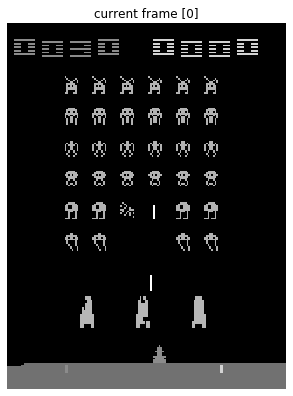

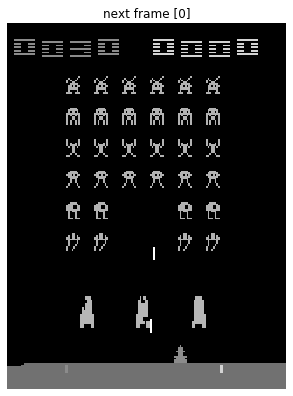

In [14]:
#get some information from  the batch to make sure it looks good.

import matplotlib.pyplot as plt

#frame_batch, next_frame_batch, actions_batch, reward_batch, frame_number_batch = get_train_batch(atari_env_train, batch_size)
frame_batch, next_frame_batch, actions_batch, next_actions_batch, reward_batch, frame_number_batch, lambda_reward_batch = get_train_batch(atari_env_train, batch_size, lambda_frames, gamma)

print("action: {}".format(actions_batch[0]))
print("reward: {}".format(reward_batch[0]))
print("frame:  {}".format(frame_number_batch[0]))

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("current frame [0]")
plt.imshow(frame_batch[0][0], cmap="gray")
plt.axis("off")
plt.show()

# plt.figure(figsize=(11, 7))
# plt.subplot(121)
# plt.title("current frame [2]")
# plt.imshow(frame_batch[0][2], cmap="gray")
# plt.axis("off")
# plt.show()

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("next frame [0]")
plt.imshow(next_frame_batch[0][0], cmap="gray")
plt.axis("off")
plt.show()

# plt.figure(figsize=(11, 7))
# plt.subplot(121)
# plt.title("next frame [2]")
# plt.imshow(next_frame_batch[0][2], cmap="gray")
# plt.axis("off")
# plt.show()

In [19]:
for i in range(500):
    reward = atari_env_train.frame_buffer[-i].getReward()
    print(reward)

0.0
-5.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0